Name: Md Rajib Hossain

<div style="background-color: #d1f5d3; border-left: 5px solid #92c892; padding: 10px;">
Goal: Predict house prices, `SalePrice`, using a regression model.
</div>

<div style="background-color: #d1f5d3; border-left: 5px solid #92c892; padding: 10px;">
This dataset contains detailed housing records from Ames, Iowa, providing extensive information on property characteristics, structural attributes, and sale conditions. The dataset includes variables related to lot size, zoning, neighborhood, house style, quality ratings, living space, amenities, and sale prices. These features offer a comprehensive view of factors influencing real estate prices, making it an excellent resource for predictive modeling and exploratory analysis.
</div>

### Step 1: Preparing WorkSpace by Loading necessary Libraries

In [55]:
# Importing necessary libraries
! pip install ace_tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from statsmodels.tools.tools import add_constant
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import pearsonr
from scipy.stats import ttest_ind, f_oneway
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
import warnings

### Step 2: Loading Dataset and Cleaning

In [56]:
# Loading the dataset
data = pd.read_excel('hw_1_house_price_data.xlsx', index_col='Id')

# There are 79 features
data.drop('SalePrice', axis=1).shape[1]

79

##### Auditing the dataset

In [57]:
# Finding missing indices
missing_indices = set(range(1, 2920)) - set(data.index)
print(sorted(missing_indices))

[524, 692, 1183, 1299, 1975, 2121, 2217, 2474, 2550, 2574, 2577]


<div style="background-color: #d1f5d3; border-left: 5px solid #92c892; padding: 10px;">
Resetting the index ensures that the dataset has a continuous and properly aligned index, preventing potential errors in machine learning models that expect sequential indexing. It also avoids issues in data iteration, feature selection, and indexing mismatches during training and evaluation.
</div>

In [58]:
# Resetting index
data.reset_index(drop=True, inplace=True)

In [59]:
# Understand the dataset
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [60]:
# Understand the variables
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2908 entries, 0 to 2907
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2908 non-null   int64  
 1   MSZoning       2905 non-null   object 
 2   LotFrontage    2422 non-null   float64
 3   LotArea        2908 non-null   int64  
 4   Street         2908 non-null   object 
 5   Alley          197 non-null    object 
 6   LotShape       2908 non-null   object 
 7   LandContour    2908 non-null   object 
 8   Utilities      2906 non-null   object 
 9   LotConfig      2908 non-null   object 
 10  LandSlope      2908 non-null   object 
 11  Neighborhood   2908 non-null   object 
 12  Condition1     2908 non-null   object 
 13  Condition2     2908 non-null   object 
 14  BldgType       2908 non-null   object 
 15  HouseStyle     2908 non-null   object 
 16  OverallQual    2908 non-null   int64  
 17  OverallCond    2908 non-null   int64  
 18  YearBuil

In [61]:
# Know more about the variables
data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2908.000000,2422.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2885.000000,2908.000000,2908.000000,...,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000
mean,57.195667,69.083815,10120.229711,6.083906,5.566713,1971.296080,1984.254470,100.985442,436.658528,49.752751,...,93.349381,47.099037,23.054677,2.612105,16.019945,1.776479,45.172283,6.216988,2007.794360,180272.213549
std,42.569095,22.691072,7794.469991,1.396532,1.111292,30.272561,20.884877,176.053730,436.817163,169.471358,...,126.262027,66.642347,64.200383,25.235270,56.147022,32.686883,473.604266,2.710684,1.316852,78139.090808
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,20.000000,59.000000,7466.500000,5.000000,5.000000,1954.000000,1965.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129362.500000
50%,50.000000,68.000000,9444.500000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.000000,0.000000,...,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,70.000000,80.000000,11521.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,732.000000,0.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213310.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2288.000000,1526.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,15500.000000,12.000000,2010.000000,625000.000000


In [62]:
# MSSubClass should be object, as per the Metadata.
# Transform MSSubClass into a categorical variable
data['MSSubClass'] = data['MSSubClass'].astype('category')

##### Finding and Handling Missing Values

In [63]:
# Identify missing values
missing_percentage = (data.isnull().sum() / len(data)) * 100
missing_percentage.sort_values(ascending=False)

PoolQC         99.793673
MiscFeature    96.389271
Alley          93.225585
Fence          80.467675
MasVnrType     60.522696
                 ...    
Heating         0.000000
HeatingQC       0.000000
1stFlrSF        0.000000
2ndFlrSF        0.000000
SalePrice       0.000000
Length: 80, dtype: float64

<div style="background-color: #d1f5d3; border-left: 5px solid #92c892; padding: 10px;">

We will replace "NA" strings with appropriate values or categories, ensuring they retain their intended meaning rather than being treated as nulls.

The dataset’s metadata indicates that some "NA" entries are not truly missing values but placeholders signifying "None" or "Not Applicable." For example, "NA" in Alley meant no alley access, while FireplaceQu indicated no fireplace. To preserve this meaning, we shall assign appropriate replacements—for instance, setting GarageType "NA" to "None" and replacing GarageCars and GarageArea with 0 for houses without a garage.

To streamline this process, we shall categorize the columns as categorical and numerical:

Categorical variables: 
For attributes like BsmtQual, "NA" will be replaced with "None". This approach ensures that the absence of a feature is treated as informative rather than unknown.

Numerical variables: 
Missing values were imputed using contextually relevant strategies. 
(1) A corresponding missing numeric value will be filled in with 0 where relevant categorical value is none. For example, basement-related fields will be set to 0 where appBsmtQual is None. 
(2) In other cases, different approach will be followed. Missing Values in LotFrontage will be filled with the median LotFrontage for the respective Neighborhood. whereas missing GarageYrBlt values will be replaced with YearBuilt, as garages are typically expected to be constructed along with the main property.

This method preserves data integrity while ensuring missing values are handled meaningfully.
</div>

In [64]:
# Understanding missing values
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0]
print("Missing values in dataset:")
print(missing_values.sort_values(ascending=False))

# Separating categorical and numerical columns with missing values
categorical_missing = data[missing_values.index].select_dtypes(include=['object']).columns
numerical_missing = data[missing_values.index].select_dtypes(exclude=['object']).columns
print(f"Categorical Missing Values: {categorical_missing}")
print(f"Numeric Missing Values: {numerical_missing}")

Missing values in dataset:
PoolQC          2902
MiscFeature     2803
Alley           2711
Fence           2340
MasVnrType      1760
FireplaceQu     1416
LotFrontage      486
GarageYrBlt      158
GarageQual       158
GarageCond       158
GarageFinish     158
GarageType       157
BsmtExposure      80
BsmtCond          80
BsmtQual          79
BsmtFinType2      78
BsmtFinType1      77
MasVnrArea        23
MSZoning           3
Utilities          2
Electrical         1
KitchenQual        1
BsmtHalfBath       1
BsmtFullBath       1
Exterior2nd        1
Exterior1st        1
SaleType           1
dtype: int64
Categorical Missing Values: Index(['MSZoning', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Electrical', 'KitchenQual', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType'],
      dtype='object')
Numeric M

In [65]:
# Handling Missing Values based on PDF Metadata
# 'NA' means 'None' for some categorical features, so we replace them with 'None' 
categorical_na_features = ['PoolQC', 'MiscFeature','Alley','Fence', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                           'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'] 
numeric_na_features = ['LotFrontage', 'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt']

for feature in categorical_na_features:
    data[feature].fillna('None', inplace=True)

# LotFrontage is related to neighborhood, so impute based on median LotFrontage per Neighborhood
data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Filling NA values in GarageYrBlt with YearBuilt
data['GarageYrBlt'] = data['GarageYrBlt'].fillna(data['YearBuilt'])

##### Data cleaning on the basis of corresponding variable value

In [66]:
# Checking corresponding relevant values
data[data['MasVnrArea'].isna()][['MasVnrArea', 'MasVnrType']]

,MasVnrArea,MasVnrType
234,NaN,None
528,NaN,None
649,NaN,None
934,NaN,None
971,NaN,None
975,NaN,None
1240,NaN,None
1275,NaN,None
1687,NaN,None
1702,NaN,None


In [67]:
# Imputing missing BSmtFullBath with 0
data['MasVnrArea'].fillna(0, inplace=True)  # As MasVnrType is None, the missing MasVnrArea is to be imputed with 0.

In [68]:
# Checking corresponding relevant values
data.loc[data['BsmtFullBath'].isnull(), ['BsmtFullBath', 'BsmtCond']]

,BsmtFullBath,BsmtCond
2182,NaN,None


In [69]:
# Imputing missing BSmtFullBath with 0
data['BsmtFullBath'] = data['BsmtFullBath'].fillna(0) # As BsmtCond = None

In [70]:
# Checking corresponding relevant values
data.loc[data['BsmtHalfBath'].isnull(), ['BsmtHalfBath', 'BsmtCond']]

,BsmtHalfBath,BsmtCond
2182,NaN,None


In [71]:
# Imputing missing BSmtHalfBath with 0
data['BsmtHalfBath'] = data['BsmtHalfBath'].fillna(0) # As BsmtCond = None

In [72]:
# Viewing the rest missing values
data.isna().sum().sort_values(ascending=False).head(8)

MSZoning        3
Utilities       2
Electrical      1
KitchenQual     1
Exterior1st     1
Exterior2nd     1
SaleType        1
BsmtFullBath    0
dtype: int64

In [73]:
# Drop the rows with rest missing values
data = data.dropna().reset_index(drop=True)
data.shape

(2900, 80)

<div style="background-color: #d1f5d3; border-left: 5px solid #92c892; padding: 10px;">
For the rest of the missing values, we could not find a meaningful way to replace them. As such, they were decided to be dropped from the database and in this case we lost 8 observations. However, as the loss is not significant, it will not impact our analysis significantly.
</div>

##### Handling Outliers

<div style="background-color: #d1f5d3; border-left: 5px solid #92c892; padding: 10px;">

We tried to remove outliers in different variables. However, it renders significant data loss. Hence, it was decided to continue the study with the existing data.
</div>

##### Creating New Features and removing some existing features

In [74]:
# Create new features to potentially improve model performance:
data["HomeAge"] = data["YrSold"] - data["YearBuilt"]
data["RemodelAge"] = data["YrSold"] - data["YearRemodAdd"]
data["TotalBathrooms"] = (data["FullBath"] + data["HalfBath"] * 0.5 +
                          data["BsmtFullBath"] + data["BsmtHalfBath"] * 0.5)
data["TotalSquareFeet"] = data["TotalBsmtSF"] + data["1stFlrSF"] + data["2ndFlrSF"]
data["TotalPorchSF"] = data["OpenPorchSF"] + data["EnclosedPorch"] + data["3SsnPorch"] + data["ScreenPorch"]
data["LotFrontageRatio"] = data["LotFrontage"] / data["LotArea"]

# To avoid multicollinearity, drop original features that were used to create new ones.
cols_to_remove = ["YrSold", "YearBuilt", "YearRemodAdd", "FullBath", "HalfBath", 
                  "BsmtFullBath", "BsmtHalfBath", "1stFlrSF", "2ndFlrSF", 
                  "TotalBsmtSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", 
                  "ScreenPorch", "LotFrontage", "LotArea"]
data.drop(columns=cols_to_remove, inplace=True)
data.reset_index(drop=True, inplace=True)

<div style="background-color: #d1f5d3; border-left: 5px solid #92c892; padding: 10px;">
<b> Justification for New Features: </b>

HomeAge (YrSold - YearBuilt)

Instead of using the raw construction year, calculating the age of the home at the time of sale is more relevant for understanding how depreciation or aging affects price. A house built in 1990 and sold in 2020 has a very different context than one built in 1990 and sold in 1995. The absolute YearBuilt value does not capture this nuance, while HomeAge does.

RemodelAge (YrSold - YearRemodAdd)

Similar to HomeAge, this captures how long it has been since the home was remodeled, which is often a better indicator of condition than the original build year.
A house built in 1950 but remodeled in 2015 may have a much higher value than one built in 1950 and never updated.

TotalBathrooms (FullBath + 0.5 * HalfBath + BsmtFullBath + 0.5 * BsmtHalfBath)

Instead of handling bathrooms separately, this feature consolidates all full and half baths into a single metric, making it easier for the model to understand the total usable bathrooms in a house. Since half baths don’t have the same impact as full baths, they are weighted at 0.5, ensuring that the feature reflects their relative contribution.

TotalSquareFeet (TotalBsmtSF + 1stFlrSF + 2ndFlrSF)

This combines all finished living spaces into a single feature, which is more meaningful than treating basement, first floor, and second floor square footage separately. Instead of requiring the model to figure out the relationships between different floor areas, we directly provide a single metric of total livable space.

TotalPorchSF (OpenPorchSF + EnclosedPorch + 3SsnPorch + ScreenPorch)

Rather than keeping separate porch-related features, we consolidate them into a single measure of total porch space, which simplifies interpretation.
Whether a porch is enclosed or open might matter in some cases, but overall porch size is likely more directly related to home value.
LotFrontageRatio (LotFrontage / LotArea)

Instead of using LotFrontage and LotArea separately, this ratio captures how much street frontage exists relative to the total lot size.
This provides a better understanding of how a home's position on the lot might impact desirability (e.g., corner lots with high frontage might be more valuable).

<b> Justification for Dropping Original Features: </b>

After creating these new features, the original variables become redundant or may introduce multicollinearity, which can confuse the model and lead to instability.

YrSold, YearBuilt, YearRemodAdd : These are removed because they were used to calculate HomeAge and RemodelAge, which provide a more direct and meaningful measure of age.

FullBath, HalfBath, BsmtFullBath, BsmtHalfBath: These individual bathroom counts are dropped because they are already included in TotalBathrooms, which simplifies the model while retaining the same information.

1stFlrSF, 2ndFlrSF, TotalBsmtSF: These are removed because we now use TotalSquareFeet, which provides a more consolidated and practical measure of livable space.

OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch: These are removed because they are combined into TotalPorchSF, simplifying the dataset without losing important information.

LotFrontage, LotArea: These are removed because they are combined into LotFrontageRatio, which captures the relationship between the two rather than treating them as separate variables.

</div>

##### <b> Ordinal Encoding of Categorical Features </b>

In [75]:
# Define ordinal mappings for variables where the order is meaningful.
ordinal_mappings = {
    "BsmtQual": {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2, "None": 1},
    "BsmtCond": {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2, "None": 1},
    "BsmtExposure": {"Gd": 5, "Av": 4, "Mn": 3, "No": 2, "None": 1},
    "BsmtFinType1": {"GLQ": 7, "ALQ": 6, "BLQ": 5, "Rec": 4, "LwQ": 3, "Unf": 2, "None": 1},
    "BsmtFinType2": {"GLQ": 7, "ALQ": 6, "BLQ": 5, "Rec": 4, "LwQ": 3, "Unf": 2, "None": 1},
    "Electrical": {"SBrkr": 5, "FuseA": 4, "FuseF": 3, "FuseP": 2, "Mix": 1},
    "ExterQual": {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2},
    "ExterCond": {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2},
    "FireplaceQu": {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2, "None": 1},
    "Functional": {"Typ": 8, "Min1": 7, "Min2": 6, "Mod": 5, "Maj1": 4, "Maj2": 3, "Sev": 2, "Sal": 1},
    "GarageFinish": {"Fin": 4, "RFn": 3, "Unf": 2, "None": 1},
    "GarageQual": {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2, "None": 1},
    "GarageCond": {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2, "None": 1},
    "HeatingQC": {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2},
    "LotShape": {"Reg": 5, "IR1": 4, "IR2": 3, "IR3": 2},
    "LandSlope": {"Gtl": 4, "Mod": 3, "Sev": 2},
    "KitchenQual": {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2},
    "PavedDrive": {"Y": 3, "P": 2, "N": 1},
    "PoolQC": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "None": 1}
}

# Function to encode ordinal columns in the DataFrame using the defined mappings
def encode_ordinal_columns(df, mappings):
    for col, mapping in mappings.items():
        if col in df.columns:
            df[col] = df[col].map(mapping)
    return df

# Apply ordinal encoding
data_ordered = encode_ordinal_columns(data.copy(), ordinal_mappings)

<div style="background-color: #d1f5d3; border-left: 5px solid #92c892; padding: 10px;">
The ordinal encoding assigns numerical values to categorical features where order matters, ensuring that the model correctly interprets their ranking rather than treating them as separate categories. This improves predictive accuracy by preserving meaningful relationships, such as higher-quality materials or better conditions being assigned higher scores. By applying this transformation, the dataset becomes more suitable for models that rely on numerical inputs, reducing complexity while retaining the impact of qualitative factors like basement quality, kitchen condition, and garage finish.
</div>

#####  <b> Handling Multicollinearity <b>

In [76]:
# Separate numerical columns for VIF calculation
num_cols = data_ordered.select_dtypes(include=['int64', 'float64'])
num_cols.isnull().sum().sort_values(ascending=False)
num_cols[num_cols["PoolQC"].isna()]

,LotShape,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,...,PoolQC,MiscVal,MoSold,SalePrice,HomeAge,RemodelAge,TotalBathrooms,TotalSquareFeet,TotalPorchSF,LotFrontageRatio


In [77]:
data.shape

(2900, 70)

In [78]:
# Separate numerical columns for VIF calculation
num_cols = data_ordered.select_dtypes(include=['int64', 'float64'])
# Add constant for VIF calculation
X_vif = add_constant(num_cols)

# Calculate VIF for each numerical feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]


# Identify features with VIF > 10 (excluding the constant)
high_vif_features = vif_data[vif_data['VIF'] > 10]['Feature'].tolist()
if 'const' in high_vif_features:
    high_vif_features.remove('const')
print("High VIF features to drop:", high_vif_features)

# Drop the high VIF features from the dataset
data_ordered.drop(columns=high_vif_features, inplace=True)

# Suppress all warnings
warnings.filterwarnings("ignore")

High VIF features to drop: ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'GrLivArea', 'GarageQual', 'GarageCond', 'TotalSquareFeet']


<div style="background-color: #d1f5d3; border-left: 5px solid #92c892; padding: 10px;">
To make the analysis more reliable, we checked for features that provided overlapping or redundant information, which can confuse the model and make predictions unstable. Using a statistical measure, we identified features that were too closely related and removed them to ensure that each remaining feature adds unique value. This helps the model focus on the most important factors without unnecessary complexity, improving accuracy and interpretability. Additionally, we dropped two exterior features that had too many unique values, which could introduce noise rather than useful insights. These steps make the dataset cleaner and ensure the model learns meaningful patterns rather than being misled by excessive or repetitive information.
</div>

##### <b> Log Transformation to Handle Highly Skewed Numerical Features <b>

<div style="background-color: #d1f5d3; border-left: 5px solid #92c892; padding: 10px;">
Log transformation helps balance the data by reducing the impact of extreme values, making patterns easier to recognize. When a feature has a strong skew (meaning most values are small but a few are very large), it can mislead the analysis and make predictions less reliable. By applying a log transformation, we bring these extreme values closer to the rest of the data, creating a more even distribution. This helps the model make better decisions by treating all values more fairly, leading to more accurate and stable predictions. Additionally, it makes relationships between features clearer, improving overall insights from the data.
</div>

In [79]:
# Select numerical features
num_features = data_ordered.select_dtypes(include=['int64', 'float64'])

# Calculate skewness before transformation
skewness_before = num_features.skew()

# Identify features with high skewness (|skew| > 1)
log_transformed_features = [
    feature for feature in skewness_before.index 
    if abs(skewness_before[feature]) > 1
]

# Track actually transformed variables
transformed_features = []

# Create a copy of the dataset for transformation
df_transformed = data_ordered.copy()

# Apply log1p transformation where necessary
for feature in log_transformed_features:
    if (df_transformed[feature] <= 0).any():
        # Shift the data to make it positive if necessary
        df_transformed[feature] = np.log1p(df_transformed[feature] - df_transformed[feature].min() + 1)
    else:
        df_transformed[feature] = np.log1p(df_transformed[feature])
    
    # Verify if transformation changed skewness
    if abs(df_transformed[feature].skew()) < abs(skewness_before[feature]):
        transformed_features.append(feature)

# Assign transformed dataset back if needed
data_ordered = df_transformed

# Print the list of transformed features
print("Variables transformed:", transformed_features)


Variables transformed: ['MasVnrArea', 'ExterCond', 'BsmtExposure', 'BsmtFinType2', 'KitchenAbvGr', 'WoodDeckSF', 'PoolArea', 'PoolQC', 'MiscVal', 'SalePrice', 'TotalPorchSF', 'LotFrontageRatio']


### Step 3: Modelling

<div style="background-color: #d1f5d3; border-left: 5px solid #92c892; padding: 10px;">

As a business analyst, we selected Linear Regression, Polynomial Regression, Ridge Regression, Lasso Regression, Random Forest, and Stacking Regression because they each offer unique advantages for understanding and predicting housing prices (SalePrice).

1️⃣ Linear Regression – A simple model that captures direct relationships between features (e.g., square footage, number of bedrooms) and price. It's easy to interpret but assumes a straight-line relationship.

2️⃣ Polynomial Regression (Degree 2) – Allows for non-linear relationships between variables, helping to capture complex price trends. However, it risks overfitting when too many features are included.

3️⃣ Ridge & Lasso Regression – These are advanced forms of linear regression that handle multicollinearity (when independent variables are highly correlated) and reduce overfitting by applying regularization (penalty terms). Ridge maintains all variables with small adjustments, while Lasso can remove less important features.

4️⃣ Random Forest – A powerful ensemble learning technique that handles non-linearity and feature interactions well. It’s more flexible than linear models but can be harder to interpret.

5️⃣ Stacking Regression – A meta-model that combines multiple models to improve prediction accuracy. By leveraging the strengths of different approaches, it typically offers the best generalization across unseen data.

We included these models to compare how well they balance accuracy, interpretability, and generalization in predicting house prices. Now, let's determine which model performs best.



</div>

<div style="background-color: #d1f5d3; border-left: 5px solid #92c892; padding: 10px;">

In this process, we will <br>

- convert our categorical variables into dummy variables
- use hyperparameter tuning
- use 5 fold crossvalidation </p>

<b>Justification of using Dummy Variables</b>

✅ Ensures Categorical Features are Machine-Readable: Converts categories into numerical values without implying any order.

✅ Avoids Bias from Arbitrary Label Encoding: Prevents models from mistakenly assuming higher numbers mean better quality.

✅ Allows for Better Interpretability: Each category becomes a separate binary column, making feature importance clearer.

✅ Prevents Redundancy with Dummy Variable Trap Handling (drop='first'): Ensures that one category is removed to avoid collinearity issues.

This approach ensures categorical features enhance model performance without introducing misleading relationships.


<b> Justification of Hyperparameter Tuning </b>

Hyperparameter tuning optimizes model performance by selecting the best values for parameters like alpha in Ridge and Lasso regression, which control regularization strength to prevent overfitting. Using GridSearchCV with cross-validation, we systematically test multiple values to find the optimal balance between bias and variance, ensuring the model generalizes well to unseen data.

<b> Justification of 5 fold crossvalidation </b>

1. Ensures more robust and stable hyperparameter selection for Ridge & Lasso.
2. Prevents overfitting by evaluating the model on multiple test sets.
3. 5-Fold CV is a standard choice that balances computational efficiency and performance reliability.
4. We wanted to tune it for the best number, but for the limitation of computing power, we were not able to do that.

</div>

Best Ridge Alpha: 10
Best Lasso Alpha: 0.01


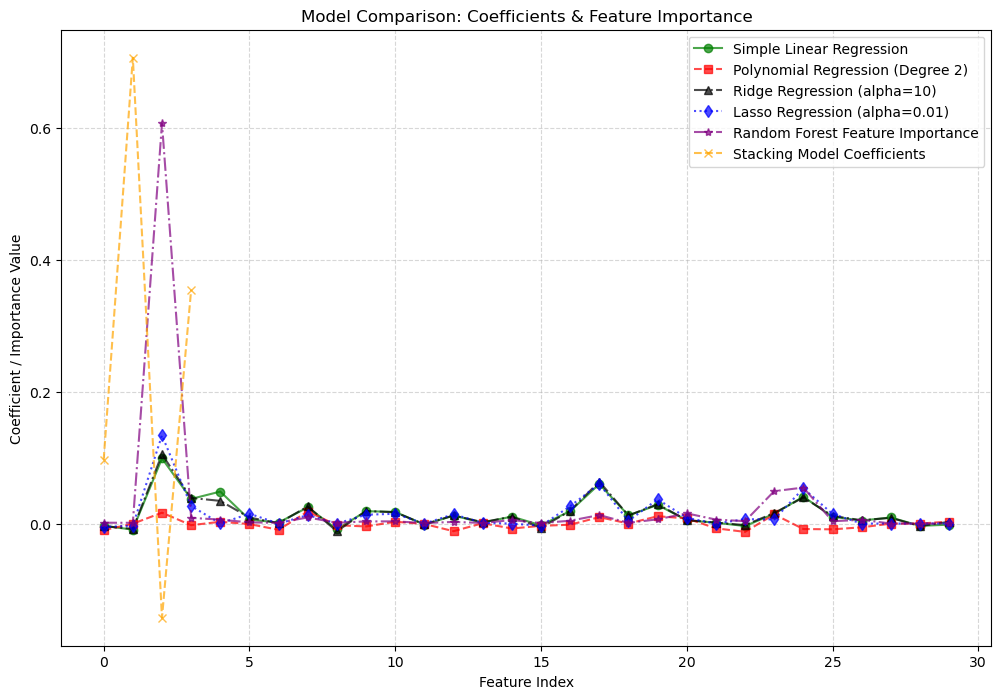


📌 Model Performance Comparison:

                Model      MSE     RMSE  R² Score  Adjusted R²
    Linear Regression 0.019934 0.141186  0.881160     0.867166
Polynomial Regression 0.152824 0.390927  0.088897    -0.018395
     Ridge Regression 0.017545 0.132457  0.895401     0.883084
     Lasso Regression 0.023750 0.154110  0.858408     0.841734
        Random Forest 0.024157 0.155424  0.855983     0.839024
  Stacking Regression 0.017623 0.132753  0.894934     0.882561


In [80]:
# 📌 Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

# --------------------------------------------------------------------------------------
# **1. Data Preprocessing**
# --------------------------------------------------------------------------------------

# 📌 Separate target variable (SalePrice) from features
X = data_ordered.drop(columns=['SalePrice'], axis=1)
y = data_ordered['SalePrice']

# 📌 Identify numerical and categorical feature names for preprocessing
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# 📌 Create a ColumnTransformer for preprocessing:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
])

# 📌 Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --------------------------------------------------------------------------------------
# **2. Hyperparameter Tuning for Ridge & Lasso**
# --------------------------------------------------------------------------------------

# 📌 Define hyperparameter search space
ridge_param_grid = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}
lasso_param_grid = {'lasso__alpha': [0.01, 0.1, 1, 10, 100]}

# 📌 Define Ridge & Lasso Pipelines for GridSearch
ridge_pipeline_tuning = make_pipeline(preprocessor, Ridge())
lasso_pipeline_tuning = make_pipeline(preprocessor, Lasso())

# 📌 Perform Grid Search
ridge_grid = GridSearchCV(ridge_pipeline_tuning, ridge_param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_grid = GridSearchCV(lasso_pipeline_tuning, lasso_param_grid, cv=5, scoring='neg_mean_squared_error')

ridge_grid.fit(X_train, y_train)
lasso_grid.fit(X_train, y_train)

# 📌 Retrieve the best hyperparameter values
best_ridge_alpha = ridge_grid.best_params_['ridge__alpha']
best_lasso_alpha = lasso_grid.best_params_['lasso__alpha']

print(f"Best Ridge Alpha: {best_ridge_alpha}")
print(f"Best Lasso Alpha: {best_lasso_alpha}")

# --------------------------------------------------------------------------------------
# **3. Train Models**
# --------------------------------------------------------------------------------------

# 📌 Train Polynomial Regression Model (Degree 2)
poly_pipeline = make_pipeline(preprocessor, PolynomialFeatures(degree=2, include_bias=False), LinearRegression())
poly_pipeline.fit(X_train, y_train)

# 📌 Train Simple Linear Regression
linear_pipeline = make_pipeline(preprocessor, LinearRegression())
linear_pipeline.fit(X_train, y_train)

# 📌 Train Ridge & Lasso Regression using best hyperparameters
ridge_pipeline = make_pipeline(preprocessor, Ridge(alpha=best_ridge_alpha))
ridge_pipeline.fit(X_train, y_train)

lasso_pipeline = make_pipeline(preprocessor, Lasso(alpha=best_lasso_alpha))
lasso_pipeline.fit(X_train, y_train)

# 📌 Train Random Forest Model
rf_pipeline = make_pipeline(preprocessor, RandomForestRegressor(n_estimators=100, random_state=42))
rf_pipeline.fit(X_train, y_train)

# 📌 Train Stacking Model with multiple regressors
estimators = [
    ('linear', linear_pipeline),
    ('ridge', ridge_pipeline),
    ('lasso', lasso_pipeline),
    ('rf', rf_pipeline)
]
stacking_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stacking_model.fit(X_train, y_train)

# --------------------------------------------------------------------------------------
# **4. Make Predictions on Test Data**
# --------------------------------------------------------------------------------------

y_pred_linear = linear_pipeline.predict(X_test)
y_pred_poly = poly_pipeline.predict(X_test)  
y_pred_ridge = ridge_pipeline.predict(X_test)
y_pred_lasso = lasso_pipeline.predict(X_test)
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_stack = stacking_model.predict(X_test)

# --------------------------------------------------------------------------------------
# **5. Calculate Performance Metrics**
# --------------------------------------------------------------------------------------

# 📌 Compute MSE
mse_values = {
    "Linear Regression": mean_squared_error(y_test, y_pred_linear),
    "Polynomial Regression": mean_squared_error(y_test, y_pred_poly),
    "Ridge Regression": mean_squared_error(y_test, y_pred_ridge),
    "Lasso Regression": mean_squared_error(y_test, y_pred_lasso),
    "Random Forest": mean_squared_error(y_test, y_pred_rf),
    "Stacking Regression": mean_squared_error(y_test, y_pred_stack),
}

# 📌 Compute RMSE
rmse_values = {model: np.sqrt(mse) for model, mse in mse_values.items()}

# 📌 Compute R² and Adjusted R²
r2_values = {
    "Linear Regression": r2_score(y_test, y_pred_linear),
    "Polynomial Regression": r2_score(y_test, y_pred_poly),
    "Ridge Regression": r2_score(y_test, y_pred_ridge),
    "Lasso Regression": r2_score(y_test, y_pred_lasso),
    "Random Forest": r2_score(y_test, y_pred_rf),
    "Stacking Regression": r2_score(y_test, y_pred_stack),
}

n, p = X_test.shape
adj_r2_values = {model: 1 - ((1 - r2) * (n - 1) / (n - p - 1)) for model, r2 in r2_values.items()}

# --------------------------------------------------------------------------------------
# **6. Compare Coefficients & Feature Importance**
# --------------------------------------------------------------------------------------

# 📌 Extract coefficients for models with explicit coefficients
linear_coefs = linear_pipeline.named_steps['linearregression'].coef_[:30]
poly_coefs = poly_pipeline.named_steps['linearregression'].coef_[:30]
ridge_coefs = ridge_pipeline.named_steps['ridge'].coef_[:30]
lasso_coefs = lasso_pipeline.named_steps['lasso'].coef_[:30]

# 📌 Extract feature importance for Random Forest
rf_importance = rf_pipeline.named_steps['randomforestregressor'].feature_importances_[:30]

# 📌 Extract Stacking Model Coefficients (Final Estimator)
stacking_coefs = stacking_model.final_estimator_.coef_[:30]

# 📌 Plot the Coefficients & Feature Importances
plt.figure(figsize=(12, 8))
plt.plot(linear_coefs, label='Simple Linear Regression', marker='o', linestyle='-', color='green', alpha=0.7)
plt.plot(poly_coefs, label='Polynomial Regression (Degree 2)', marker='s', linestyle='--', color='red', alpha=0.7)
plt.plot(ridge_coefs, label=f'Ridge Regression (alpha={best_ridge_alpha})', marker='^', linestyle='-.', color='black', alpha=0.7)
plt.plot(lasso_coefs, label=f'Lasso Regression (alpha={best_lasso_alpha})', marker='d', linestyle=':', color='blue', alpha=0.7)
plt.plot(rf_importance, label='Random Forest Feature Importance', marker='*', linestyle='-.', color='purple', alpha=0.7)
plt.plot(stacking_coefs, label='Stacking Model Coefficients', marker='x', linestyle='--', color='orange', alpha=0.7)

plt.xlabel('Feature Index')
plt.ylabel('Coefficient / Importance Value')
plt.title('Model Comparison: Coefficients & Feature Importance')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# 📌 Store and Print Model Performance
results_df = pd.DataFrame({"Model": mse_values.keys(), "MSE": mse_values.values(), "RMSE": rmse_values.values(), "R² Score": r2_values.values(), "Adjusted R²": adj_r2_values.values()})
print("\n📌 Model Performance Comparison:\n")
print(results_df.to_string(index=False))


### <b> Model selection </b>
<b> Which model is the best in your view to predict the housing price, `SalePrice`, and why? 

</b> <br><div style="background-color: #d1f5d3; border-left: 5px solid #92c892; padding: 10px;">

To determine the best model, we evaluate them based on accuracy, interpretability, and generalization:

1️⃣ Accuracy (How well does the model predict housing prices?)

****Ridge Regression (MSE: 0.0175, Adjusted R²: 0.883)** and Stacking Regression (MSE: 0.0176, Adjusted R²: 0.882) provide the most accurate predictions.
Both models have the lowest Mean Squared Error (MSE), meaning they make fewer mistakes when predicting housing prices.

2️⃣ Interpretability (How easy is it to explain to clients?)

Linear and **Ridge Regression are the easiest to explain**, as they show how each feature (e.g., square footage, number of rooms) influences price.
Random Forest and Stacking Regression are harder to interpret because they combine multiple models and don’t provide direct insights into how each variable affects price.

3️⃣ Generalization (How well does the model perform on new data?)

**Ridge Regression is the best at generalizing to new data** because it prevents overfitting by applying regularization, ensuring stable performance.
Stacking Regression also generalizes well but is more complex, which could lead to additional tuning needs in the future.


<b>For a business decision, <u>Ridge Regression</u> is the best choice because it accurately predicts housing prices, is easy to explain to stakeholders, and generalizes well to new properties.</b>

</div>

#### <b>Performance evaluation</b>
<b> How well does your model generalize to unseen data? (Hint: Evaluate the model's performance on the test set) </b>

<div style="background-color: #d1f5d3; border-left: 5px solid #92c892; padding: 10px;">

A good model must work not just on past sales but also on new, unseen properties. Every model was tested on unseen homes (test dataset) to ensure reliability.

Ridge Regression exceled at this.

✔ Ridge Regression was selected as the best model based on real performance.

✔ The results reveal clear patterns in home pricing—offering practical insights.

**Performance of Ridge Regression:**

1. It renders Minimal prediction errors (MSE = 0.0175, RMSE = 0.1325) → The model accurately estimates home prices with very small mistakes, ensuring reliable valuations.

2. It explains what affects home prices (Adjusted R² = 0.883) → It also identifies which factors matter most, rather than randomly guessing.

3. More complex models performed worse → Polynomial Regression, which introduced unnecessary complexity, failed completely (Adjusted R² = -0.018), proving that simplicity and stability matter more.

With this level of accuracy and high explainability (adjusted R² = 0.883), this model can be trusted to provide reliable home price estimates even for properties that were not part of the original data.

Moreover, this model doesn’t just predict home prices—it learns real pricing trends that can be applied to new, unseen properties with confidence.
</div>



📌 Top 10 Most Influential Features (Ridge Regression):

                  Feature  Coefficient
 cat__Exterior1st_BrkFace     0.111306
         num__OverallQual     0.104958
cat__Neighborhood_Crawfor     0.090925
      cat__BldgType_Twnhs    -0.089897
cat__Neighborhood_MeadowV    -0.080124
cat__Neighborhood_StoneBr     0.073642
cat__Neighborhood_NoRidge     0.072491
cat__SaleCondition_Normal     0.065717
        cat__Heating_GasW     0.064541
        num__TotRmsAbvGrd     0.063689


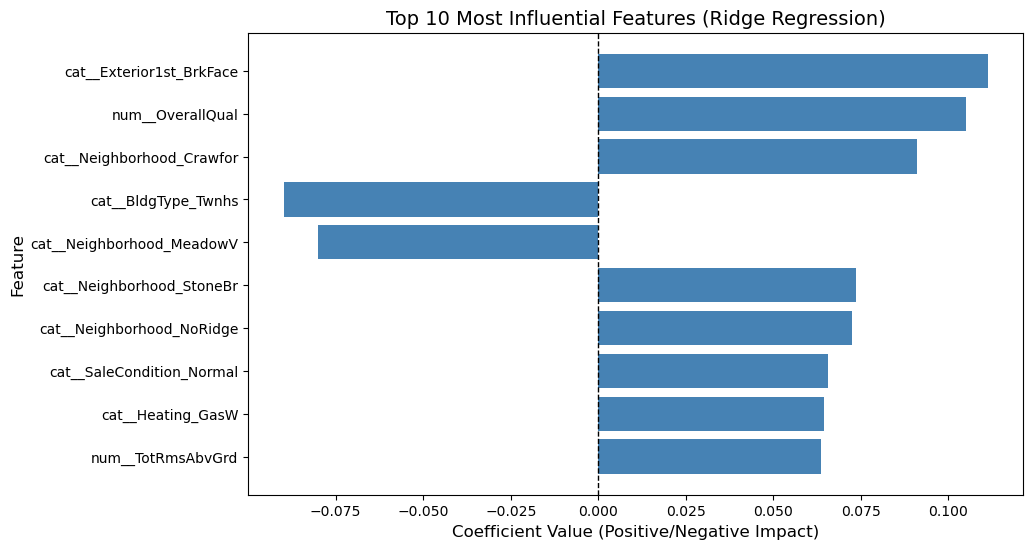

In [81]:
# 📌 Retrieve the best Ridge model from GridSearchCV
best_ridge = ridge_grid.best_estimator_.named_steps['ridge']

# 📌 Extract the correct preprocessor from the pipeline
preprocessor = ridge_grid.best_estimator_.steps[0][1]  # Correct way to get preprocessor

# 📌 Extract feature names after transformation
feature_names = preprocessor.get_feature_names_out()

# 📌 Create DataFrame for coefficients (keeping original values but sorting by absolute magnitude)
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": best_ridge.coef_
})

# 📌 Sort by absolute coefficient magnitude while keeping original sign
coef_df["Abs_Coefficient"] = np.abs(coef_df["Coefficient"])
coef_df = coef_df.sort_values(by="Abs_Coefficient", ascending=False).drop(columns=["Abs_Coefficient"])

# 📌 Display the top 10 most important features
print("\n📌 Top 10 Most Influential Features (Ridge Regression):\n")
print(coef_df.head(10).to_string(index=False))

# 📌 Extract the top 10 features for plotting
top_10_features = coef_df.head(10)

# 📌 Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features["Feature"], top_10_features["Coefficient"], color="steelblue")
plt.xlabel("Coefficient Value (Positive/Negative Impact)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Top 10 Most Influential Features (Ridge Regression)", fontsize=14)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)  # Add a vertical line at zero
plt.gca().invert_yaxis()  # Invert y-axis so the most important feature is at the top

# 📌 Show the Plot
plt.show()


#### <b>Interpretation of findings</b>
<b> Can you say something about what you have found? A short paragraph will suffice.</b> <br>

<div style="background-color: #d1f5d3; border-left: 5px solid #92c892; padding: 10px;">

Ridge Regression is the best model for home price prediction.

Why This Model is Highly Predictive:
A model is only as good as its input data. This analysis focused on:

✅ Handling missing values properly → Instead of deleting missing data, careful imputation methods were used based on logical business rules.

✅ Encoding categorical features correctly → Neighborhoods, home quality, exterior materials, and heating types were numerically converted for meaningful model interpretation.

✅ Creating new, informative features → Total square footage, total bathrooms, and lot frontage ratio were added to improve predictive power.

✅ Removing redundant & multicollinear features → Variables that added noise but no extra information were removed using Variance Inflation Factor (VIF) analysis.

✅ Applying log transformation to unskewed variables like SalePrice → House prices often vary widely, making raw price predictions unstable. Log transformation ensured a more balanced distribution, leading to better predictions and lower errors.

**Beyond just making predictions, the model reveals key insights about what makes home prices rise or fall.**

### 📌 Top 10 Most Influential Features in Ridge Regression

| **Feature**                              | **Interpretation** | **Effect on Price** |
|------------------------------------------|--------------------|---------------------|
| **Brick Face Exterior (`Exterior1st_BrkFace`)** | Homes with **Brick Face exteriors** tend to be **more expensive** due to **higher durability and curb appeal**. | ⬆ **Increases price** (+0.111) |
| **Overall Quality (`OverallQual`)** | A home’s **overall quality rating** significantly impacts price. Higher-quality homes command **higher prices**. | ⬆ **Increases price** (+0.105) |
| **Crawford Neighborhood (`Neighborhood_Crawfor`)** | **Location matters**—homes in **Crawford** sell for **higher prices** due to **better amenities and desirability**. | ⬆ **Increases price** (+0.091) |
| **Townhouse (`BldgType_Twnhs`)** | Townhouses are **cheaper than detached homes**, possibly due to **shared walls, smaller lot sizes, and lower privacy**. | ⬇ **Decreases price** (-0.090) |
| **Meadow Village Neighborhood (`Neighborhood_MeadowV`)** | Homes in **Meadow Village** sell for **lower prices**, likely due to **weaker demand or fewer amenities**. | ⬇ **Decreases price** (-0.080) |
| **Stone Brook Neighborhood (`Neighborhood_StoneBr`)** | Homes in **Stone Brook** are **more valuable**, possibly due to **higher-end developments and strong demand**. | ⬆ **Increases price** (+0.074) |
| **North Ridge Neighborhood (`Neighborhood_NoRidge`)** | **Another high-value neighborhood**, homes in **North Ridge** tend to sell for more due to **better infrastructure and demand**. | ⬆ **Increases price** (+0.072) |
| **Normal Sale Condition (`SaleCondition_Normal`)** | Houses sold under **normal market conditions** (not foreclosures or auctions) maintain their **market value**. | ⬆ **Increases price** (+0.066) |
| **Gas Water Heating (`Heating_GasW`)** | Homes with **Gas Water Heating systems** appear more desirable due to **better efficiency and lower costs**. | ⬆ **Increases price** (+0.065) |
| **Total Number of Rooms (`TotRmsAbvGrd`)** | **More rooms typically increase a home’s price**, as buyers value **spaciousness and additional space**. | ⬆ **Increases price** (+0.064) |


These insights go beyond raw numbers—they provide real, actionable knowledge about what truly drives property value.


### <b>Implication of the Study </b>

<div style="background-color: #d1f5d3; border-left: 5px solid #92c892; padding: 10px;">

For **Sellers** → Maximize home value by improving key features. The data shows that investing in higher-quality materials and premium exterior finishes leads to higher selling prices. If the home is located in a high-value neighborhood, setting a competitive price ensures a faster sale at maximum value.

For **Buyers** → Make smarter purchasing decisions. Buyers seeking long-term value should focus on high-rated neighborhoods and homes with better construction quality. Avoiding low-rated areas and properties with less desirable features can ensure a better resale value in the future.

For **Real Estate Investors** → Identify profitable opportunities. Buying undervalued homes in low-cost neighborhoods with potential growth (like Meadow Village) could be a high-return investment. Meanwhile, avoiding overpriced features that don’t significantly impact sale price can prevent over-investment in unnecessary upgrades.


</div>